Apple Stock Market: https://www.kaggle.com/datasets/meetnagadia/apple-stock-price-from-19802021

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
apple = pd.read_csv("desktop/Apple/Apple_2005_2019.csv")
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2005,1.156786,1.162679,1.117857,1.130179,0.966323,691992000
1,4/1/2005,1.139107,1.169107,1.124464,1.141786,0.976247,1096810400
2,5/1/2005,1.151071,1.165179,1.143750,1.151786,0.984798,680433600
3,6/1/2005,1.154821,1.159107,1.130893,1.152679,0.985561,705555200
4,7/1/2005,1.160714,1.243393,1.156250,1.236607,1.057321,2227450400


We will create a new feature called 'Average' that calculates the average between Open and Close. We will build our model using this feature.

In [3]:
apple['Average'] = ( apple['Open'] + apple['Close'] ) / 2
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Average
0,3/1/2005,1.156786,1.162679,1.117857,1.130179,0.966323,691992000,1.143483
1,4/1/2005,1.139107,1.169107,1.124464,1.141786,0.976247,1096810400,1.140446
2,5/1/2005,1.151071,1.165179,1.143750,1.151786,0.984798,680433600,1.151428
3,6/1/2005,1.154821,1.159107,1.130893,1.152679,0.985561,705555200,1.153750
4,7/1/2005,1.160714,1.243393,1.156250,1.236607,1.057321,2227450400,1.198660


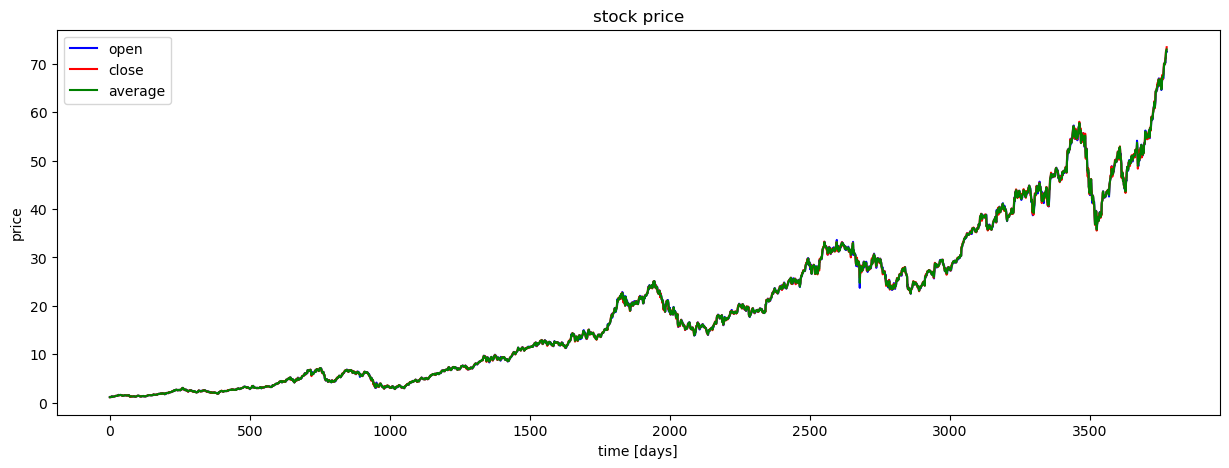

In [4]:
plt.figure(figsize=(15,5));
plt.plot(apple.Open.values, color='blue', label='open')
plt.plot(apple.Close.values, color='red', label='close')
plt.plot(apple.Average.values, color='green', label='average')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

## Split Train and Test

If we randomly choose samples for train and test, we might find several train samples similar to the test ones and get high accuracy, but this would be fake. 

Therefore we will split the train and test set between the first 80% samples and the last 20%.

In [5]:
test_size = 0.2
k = np.round(len(apple)*(1-test_size)).astype(int)
apple_train, apple_test = apple[:k], apple[k:]
print("{} train samples, {} test samples".format(apple_train.shape[0], apple_test.shape[0]))

3020 train samples, 755 test samples


In [6]:
apple_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Average
0,3/1/2005,1.156786,1.162679,1.117857,1.130179,0.966323,691992000,1.143483
1,4/1/2005,1.139107,1.169107,1.124464,1.141786,0.976247,1096810400,1.140446
2,5/1/2005,1.151071,1.165179,1.143750,1.151786,0.984798,680433600,1.151428
3,6/1/2005,1.154821,1.159107,1.130893,1.152679,0.985561,705555200,1.153750
4,7/1/2005,1.160714,1.243393,1.156250,1.236607,1.057321,2227450400,1.198660


In [7]:
average_train = apple_train.iloc[:,7:].values
average_train

array([[ 1.1434825],
       [ 1.1404465],
       [ 1.1514285],
       ...,
       [29.2225   ],
       [29.285    ],
       [29.1475   ]])

In [8]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))
apple_scaled = sc.fit_transform(average_train)
apple_scaled

array([[9.48800286e-05],
       [0.00000000e+00],
       [3.43205690e-04],
       ...,
       [8.77610685e-01],
       [8.79563914e-01],
       [8.75266811e-01]])

In [9]:
x_train = []
y_train = []

k = 1 
lent = apple_scaled.shape[0]

for i in range(k,lent):
    x_train.append(apple_scaled[i-k:i, 0])
    y_train.append(apple_scaled[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)

print(x_train.shape, y_train.shape)

(3019, 1) (3019,)


In [10]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

## Baseline: RNN

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

apple_rnn = Sequential()
apple_rnn.add(SimpleRNN(units = 50,return_sequences = True,input_shape = (x_train.shape[1],1)))

Metal device set to: Apple M1 Max


2022-11-21 20:08:33.079127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-21 20:08:33.079255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
apple_rnn.add(Dropout(0.2))
apple_rnn.add(SimpleRNN(units = 50,return_sequences = False))
apple_rnn.add(Dropout(0.2))
apple_rnn.add(Dense(units = 1))

In [13]:
import tensorflow as tf

apple_rnn.compile(optimizer = 'adam',loss = 'mean_squared_error')

with tf.device('/cpu:0'):
    apple_rnn.fit(x_train,y_train,epochs = 100, batch_size = 32)

Epoch 1/100


2022-11-21 20:08:33.231620: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/95 [..............................] - ETA: 1:07 - loss: 0.1917

2022-11-21 20:08:33.804013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 1s 5ms/step - loss: 0.0225
Epoch 2/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 3/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 4/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 5/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 6/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 7/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 8/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 9/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 10/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 11/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 12/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 13/100
95/95 [=============================

In [14]:
real_stock_apple = apple_test.iloc[:,7:].values

In [15]:
dataset_total = apple['Average']

inputs = dataset_total[len(dataset_total) - len(apple_test)-k:].values

In [16]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [17]:
x_test = []

lent2 = apple_test.shape[0]

for i in range(k,lent2):
    x_test.append(inputs[i-k:i,0])
    
x_test = np.array(x_test)
x_test.shape

(754, 1)

In [18]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(754, 1, 1)

## RNN Prediction

In [19]:
predicted_price = apple_rnn.predict(x_test)

24/24 [==============================] - 0s 6ms/step


2022-11-21 20:09:15.970435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [20]:
predicted_price.shape

(754, 1)

In [21]:
predicted_price = sc.inverse_transform(predicted_price)

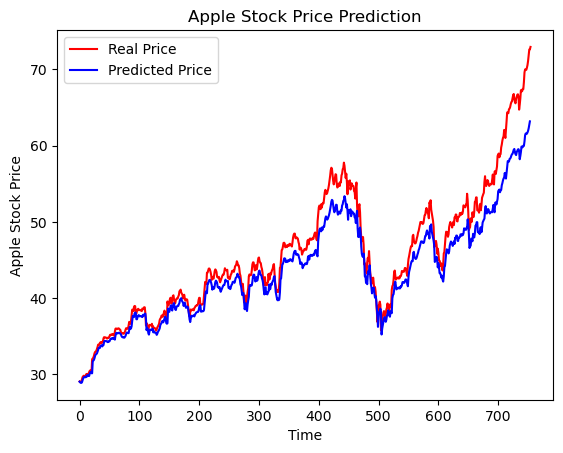

In [22]:
plt.plot(real_stock_apple,color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [23]:
real_stock_apple.shape

(755, 1)

In [24]:
from sklearn.metrics import r2_score

real_stock_apple = real_stock_apple[:(len(real_stock_apple)-k)]

for i in range(real_stock_apple.shape[1]):
    print(r2_score(real_stock_apple[:, i], predicted_price[:, i]))

0.8943320267298761


## Experiment 1 LSTM

In [25]:
from keras.layers import LSTM

apple_lstm = Sequential()
apple_lstm.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train.shape[1],1)))

In [26]:
apple_lstm.add(Dropout(0.2))
apple_lstm.add(LSTM(units = 50,return_sequences = False))
apple_lstm.add(Dropout(0.2))
apple_lstm.add(Dense(units = 1))

In [27]:
apple_lstm.compile(optimizer = 'adam',loss = 'mean_squared_error')

with tf.device('/cpu:0'):
    apple_lstm.fit(x_train,y_train,epochs = 100, batch_size = 32)

Epoch 1/100


2022-11-21 20:09:17.714567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 2s 4ms/step - loss: 0.0853
Epoch 2/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 3/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 4/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 5/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 6/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 7/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 8/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 9/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 10/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 11/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 12/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 13/100
95/95 [=============================

In [28]:
predicted_price_lstm = apple_lstm.predict(x_test)

24/24 [==============================] - 1s 3ms/step


2022-11-21 20:09:57.617688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 20:09:57.665369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 20:09:57.691751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [29]:
predicted_price_lstm = sc.inverse_transform(predicted_price_lstm)

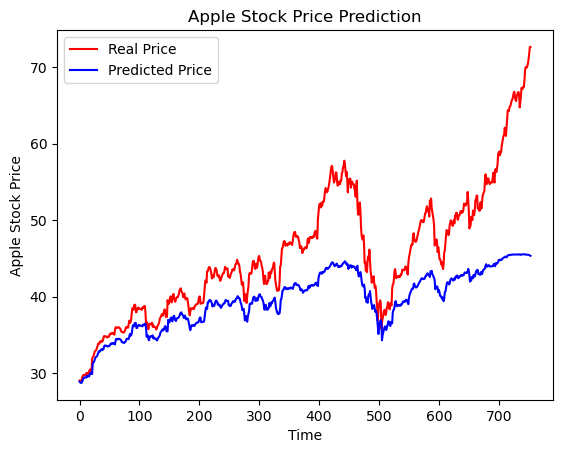

In [30]:
plt.plot(real_stock_apple,color = 'red', label = 'Real Price')
plt.plot(predicted_price_lstm, color = 'blue', label = 'Predicted Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [31]:
for i in range(real_stock_apple.shape[1]):
    print(r2_score(real_stock_apple[:, i], predicted_price_lstm[:, i]))

0.1460723358988939


## Experiment 2 LSTM - No Dropouts

In [52]:
apple_lstm_2 = Sequential()
apple_lstm_2.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train.shape[1],1)))

In [53]:
apple_lstm_2.add(LSTM(units = 50,return_sequences = False))
apple_lstm_2.add(Dense(units = 1))

In [54]:
apple_lstm_2.compile(optimizer = 'adam',loss = 'mean_squared_error')

with tf.device('/cpu:0'):
    apple_lstm_2.fit(x_train,y_train,epochs = 100, batch_size = 32)

Epoch 1/100


2022-11-21 20:30:58.948517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 2s 4ms/step - loss: 0.0973
Epoch 2/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 3/100
95/95 [==============================] - 0s 4ms/step - loss: 5.6867e-04
Epoch 4/100
95/95 [==============================] - 0s 4ms/step - loss: 4.5155e-04
Epoch 5/100
95/95 [==============================] - 0s 4ms/step - loss: 3.4153e-04
Epoch 6/100
95/95 [==============================] - 0s 4ms/step - loss: 2.4534e-04
Epoch 7/100
95/95 [==============================] - 0s 4ms/step - loss: 1.6918e-04
Epoch 8/100
95/95 [==============================] - 0s 4ms/step - loss: 1.1437e-04
Epoch 9/100
95/95 [==============================] - 0s 4ms/step - loss: 8.1485e-05
Epoch 10/100
95/95 [==============================] - 0s 4ms/step - loss: 6.3541e-05
Epoch 11/100
95/95 [==============================] - 0s 4ms/step - loss: 5.6568e-05
Epoch 12/100
95/95 [==============================] - 0s 4ms/step - loss: 5.5052e-05
Epoch 13/

In [55]:
predicted_price_lstm_2 = apple_lstm_2.predict(x_test)

24/24 [==============================] - 1s 3ms/step


2022-11-21 20:31:42.063794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 20:31:42.111951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-21 20:31:42.134861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [56]:
predicted_price_lstm_2 = sc.inverse_transform(predicted_price_lstm_2)

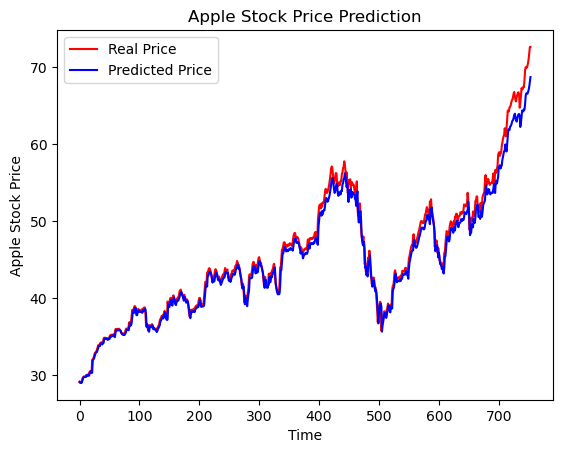

In [57]:
plt.plot(real_stock_apple,color = 'red', label = 'Real Price')
plt.plot(predicted_price_lstm_2, color = 'blue', label = 'Predicted Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [58]:
for i in range(real_stock_apple.shape[1]):
    print(r2_score(real_stock_apple[:, i], predicted_price_lstm_2[:, i]))

0.9811742529412535
